In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset_path = "/kaggle/input/face-recognition-dataset-preprocessed/data.pkl"
print(dataset_path)

/kaggle/input/face-recognition-dataset-preprocessed/data.pkl


In [3]:
import pickle
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)

In [4]:
(train_imgs, train_labels), (val_imgs, val_labels) = data

train_imgs = train_imgs.astype('float32') / 255.0
val_imgs = val_imgs.astype('float32') / 255.0

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (5728, 256, 256, 3)
Training labels shape: (5728,)
Validation images shape: (1432, 256, 256, 3)
Validation labels shape: (1432,)


In [5]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_hot = to_categorical(train_labels, num_classes=4)
val_labels_hot = to_categorical(val_labels, num_classes=4)


In [6]:
class_names = ['ashfaq', 'khalid', 'rifat', 'shafin']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_imgs)

# Generate a batch of augmented images from the datagen
augmented_images, _ = next(datagen.flow(train_imgs, train_labels_hot, batch_size=32)) 

plt.figure(figsize=(10, 10)) 

for i in range(32):
    plt.subplot(8, 4, i + 1)  
    plt.imshow(augmented_images[i])
    plt.axis('off') 

plt.show()

In [9]:
from tensorflow.keras import models, layers, applications, optimizers

# Load a pre-trained model (e.g., MobileNetV2) without the top classification layer
base_model = applications.ResNet50(
    input_shape=(256, 256, 3),  # Input shape for your images
    include_top=False,          # Exclude the top classification layer
    weights='imagenet'          # Load weights pre-trained on ImageNet
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Create the transfer learning model
model = models.Sequential([
    # Pre-trained base model
    base_model,

    # Add custom layers for face recognition
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
    layers.Dense(128, activation='relu'),  # Dense layer for feature extraction
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune only the last few layers of the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the updated model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 4,728,452 (18.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    datagen.flow(train_imgs, train_labels_hot, batch_size=6),
    epochs=50,
    validation_data=(val_imgs, val_labels_hot),
    callbacks=[early_stopping],
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


955/955 ━━━━━━━━━━━━━━━━━━━━ 103s 92ms/step - accuracy: 0.4201 - loss: 1.2737 - val_accuracy: 0.8855 - val_loss: 0.4761
Epoch 2/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 71s 74ms/step - accuracy: 0.8193 - loss: 0.5727 - val_accuracy: 0.9392 - val_loss: 0.2806
Epoch 3/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 71s 74ms/step - accuracy: 0.8863 - loss: 0.3696 - val_accuracy: 0.9539 - val_loss: 0.1716
Epoch 4/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 72s 74ms/step - accuracy: 0.9137 - loss: 0.2933 - val_accuracy: 0.9742 - val_loss: 0.0917
Epoch 5/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 72s 75ms/step - accuracy: 0.9271 - loss: 0.2367 - val_accuracy: 0.9721 - val_loss: 0.0967
Epoch 6/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 72s 74ms/step - accuracy: 0.9361 - loss: 0.2030 - val_accuracy: 0.9092 - val_loss: 0.2376
Epoch 7/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 71s 74ms/step - accuracy: 0.9490 - loss: 0.1642 - val_accuracy: 0.9693 - val_loss: 0.1158
Epoch 8/50
955/955 ━━━━━━━━━━━━━━━━━━━━ 71s 74ms/step - accuracy: 0.9542 - loss: 0.1554 - val_accura

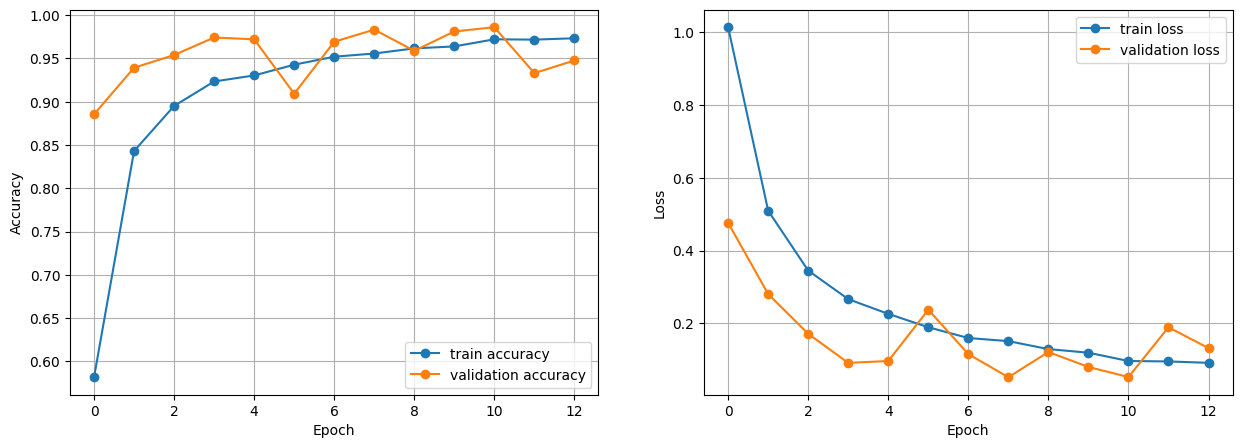

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [12]:
predictions = model.predict(val_imgs)

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step


In [13]:
predicted_classes = np.argmax(predictions, axis=1)
confidence_levels = np.max(predictions, axis=1)

fig, axes = plt.subplots(10, 10, figsize=(20, 20))  
axes = axes.ravel()  

for i in range(100):  
    axes[i].imshow(val_imgs[i]) 
    axes[i].axis('off')  

    true_label = class_names[val_labels[i]]
    predicted_label = class_names[predicted_classes[i]]
    confidence = confidence_levels[i]

    color = "green" if predicted_classes[i] == val_labels[i] else "red"

    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", color=color, fontsize=8)

plt.tight_layout()
plt.show()


In [14]:
model.save('/kaggle/working/face_recognition_model.keras')

In [15]:
with open('class_labels.pkl', 'wb') as file:
    pickle.dump(class_names, file)